# Modeling single-cell perturbation responses

In massively multiplexed experiments, advances in single-cell experimental protocols allow measuring hundreds of thousands of cells under thousands of unique conditions {cite}`srivatsan2020`. Recently, such technologies have been adapted to profile CRISPR-Cas9 with multimodal readouts level {cite}`Papalexi2021,frangieh2021`, {cite} genome-wide perturbations`replogle2021`, and {cite} combinatorial perturbations {cite}`wessels2022`. Despite experimental advances, exploring the massive perturbation space of combinatorial gene knock-outs or drug combinations remains challenging. The massive exploration space motivated the development of computational approaches for modeling single-cell perturbation responses {cite} `ji2021`. Perturbation methods aim to predict transcriptomic response to stimuli, be it drugs, genetic knock-outs, or disease, for unseen populations where the perturbation response has not been measured. Multiple methods have been developed based on autoencoders{cite}`Lotfollahi 2019,2020,2021,russkikh2020, yuan2021,amodio2018,wei2022`, a deep learning framework to learn a low-dimensional representation of the data. Here, we demonstrate the application of {cite} scGen `Lotfollahi 2019`, a variational autoencoder combined with vector arithmetics. The model learns a latent representation of the data in which it estimates a difference vector between control (untreated) and perturbed (treated) cells. The estimated difference vector is then added to control cells for the cell type or population of interest to predict the gene expression response for each single cell.

### An example application of perturbation models   


As we already outlined, the main application of perturbation response modeling is to help facilitate experimental design and hypothesis generation. The failure to capture cells treated with a perturbation could happen when a specific population could not be measured due to experimental or sample failure (e.g., failed cell sorting), high experimental costs prohibiting exploring all possibilities, and rare frequency of discovery for some cell types. In all scenarios above,  an in-slilico prediction of the missing population can lead to an informed decision about conducting new experiments or not. Here, we demonstrate the application scGen to predict the response to IFN-β for a population of  CD4-T cells that are artificially held out (unseen) during training to simulate a real-world scenario mentioned before. To this end, we leverage a dataset contains PBMCs from eight patients with Lupus treated with IFN-β or left untreated from
{cite}`kang2018` across seven different cell-types.

In [1]:
import logging
import scanpy as sc
import scgen

Global seed set to 0


### Loading the data

In [2]:
adata = sc.read(
    "./kang_raw.h5ad",
    backup_url="https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk",
)

  0%|          | 0.00/22.4M [00:00<?, ?B/s]

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


This dataset contains PBMCs {cite}`kang2018` across seven different cell-types.

In [7]:
adata.obs.cell_type.value_counts()

CD4T           5564
FCGR3A+Mono    3601
CD14+Mono      2561
B              1811
NK             1163
CD8T           1115
Dendritic      1078
Name: cell_type, dtype: int64

We remove CD4T cells from training data to simulate a real-world scenario of not capturing a specific population during an experiment.

In [46]:
adata_t = adata[
    ~((adata.obs["cell_type"] == "CD4T") & (adata.obs["condition"] == "stimulated"))
].copy()

cd4t_stim = adata[
    ((adata.obs["cell_type"] == "CD4T") & (adata.obs["condition"] == "stimulated"))
].copy()

Here we set up the anndata. scGen requires the data to be in a particular format which is facilitated using `anndata`. However, this is made easy through scGen's "setup_anndata" function, which requires the key of the sample (in our case, "condition") and the cell type label key ("cell_type") which are later used for the model's internal computations.

In [19]:
scgen.SCGEN.setup_anndata(adata_t, batch_key="condition", labels_key="cell_type")

### Model construction and training

scGen requires the modified `anndata` onbject (adata_t) to construct the model object, which can be used to train the model. This function receives multiple user inputs, including the number of nodes in each hidden layer (`n_hidden` bellow) of the model before the bottleneck layer (the middle layer of the network) and also the number of such layers (`n_layers`). Additionally, the user can adapt the dimension of the bottleneck layer, which is used to calculate the difference vector between perturbed cells and control cells. The parameters used here are taken from the original publication as default. In practice, wider hidden layers lead to better reconstruction accuracy, which is essential for our aim to predict the perturbation response across many genes.

In [ ]:
model = scgen.SCGEN(adata_t,
                   n_hidden=800,
                   n_latent=100
                   n_layers=2)

scGen is a neural network with thousands of parameters to learn a low-dimensional data representation. Here, we use `train` method to estimate these parameters using the training data. There are multiple parameters here, `max_epochs` is the maximum number of iterations the model is allowed to update its parameters which are set to 100 here. The higher values training epochs will take more computation time but might help better results. The `batch_size` is the number of samples (individual cells) the model sees to update its parametes. The lower numbers usually lead to better results in the case of scGen. Finally, there is `early_stopping`, which enables the model to stop the training if its results are not improved after `early_stopping_patience` training epochs. The early stopping mechanism prevents potential overfitting of the training data, which can lead to poor generalization to unseen populations.  

In [22]:
model.train(
    max_epochs=100, batch_size=32, early_stopping=True, early_stopping_patience=25
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29/100:  29%|██▉       | 29/100 [01:48<04:25,  3.74s/it, loss=73.4, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 499.229. Signaling Trainer to stop.


To visualize the learned representation of data by the model, we plot the latent representation of the model using the UMAP algorithm. The `get_latent_representation()`  returns a 100-dimensional vector for each cell used as the input of UMAP algorithm.

In [25]:
adata_t.obsm["scgen"] = model.get_latent_representation()

scanpy's internal commands to calculate neighborhood graph, calculate UMAP embedding, and plot it.

In [28]:
sc.pp.neighbors(adata_t, use_rep="scgen")
sc.tl.umap(adata_t)

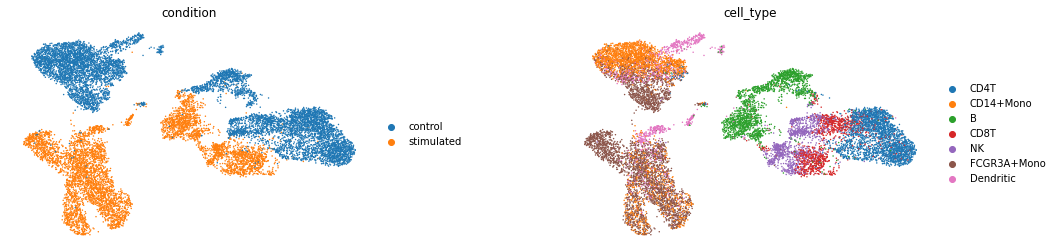

In [29]:
sc.pl.umap(adata_t, color=["condition", "cell_type"], wspace=0.4, frameon=False)

As observed above, the IFN-β stimulation indcuced strong transcriptional changes across all cell-types 

### Predciting CD4T reponses to IFN-β

After the model is trained, we can ask the model to simulate the effect of IFN-β response for each control CD4T cells present in the training data. The prediction is made possible via the `predict` method, which receives the corresponding labels (`ctrl_key` and `stim_key` below) in the `condition` (as provided earlier by the user) column of the `anndata` to estimate a global the difference vector in the latent space between 'control' and 'stimulated' cells. This vector is then added to each single-cell present specified in `celltype_to_predict` (here CD4T). 



In [42]:
pred, delta = model.predict(
    ctrl_key="control", stim_key="stimulated", celltype_to_predict="CD4T"
)

# we annotate the predicted cells to distinguish them later from ground truth cells.
pred.obs["condition"] = "predicted stimulated"

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


### Evaluating single-cell perturbation responses

In previous sections, we predicted the response to IFN-β for each CD4T cell present among the control population. Since single-cell sequencing is destructive, meaning that cells can not be measured before and after a particular perturbation. Thus, it is impossible to directly evaluate the prediction for the same cell after IFN-β stimulation. However, we have a group of cells in the data treated with IFN-β, which we can use to measure how well the predicted cell population aligns with ground truth cells. To pursue this, we evaluate predictions qualitatively by looking at the embedding of control, predicted, and actual CD4t IFN-β cells in principal component analysis (PCA) space. Additionally, we also quantitatively measure the correlation between mean gene expression of predicted cells and IFN-β across all genes and differentially expressed genes after  IFN-β stimulaton.

First, we construct an object containing control, predicted stimulated, and actual stimulated cells.

In [47]:
ctrl_adata = adata[
    ((adata.obs["cell_type"] == "CD4T") & (adata.obs["condition"] == "control"))
]
# concatenate pred, control and real CD4T cells in to one object
eval_adata = ctrl_adata.concatenate(cd4t_stim, pred)

In [48]:
eval_adata.obs.condition.value_counts()

stimulated              3127
control                 2437
predicted stimulated    2437
Name: condition, dtype: int64

We first look at the PCA co-embedding of control, IFN-β stimulated and predicted CD4T cells.

... storing 'condition' as categorical


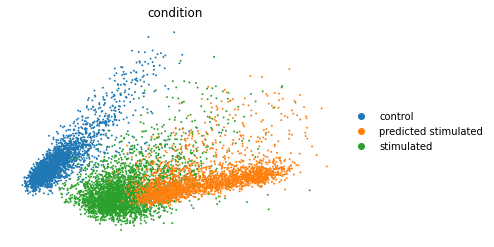

In [49]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

As observed above, the control cells were moved toward the CD4T stimulated cells with IFN-β. Yet we need to look at differentially expressed genes (DEGs). Bellow, we look at the overall mean correlation of predicted and real cells. Before that, we extract DEGs between control and stimulated cells:

In [53]:
cd4t_adata = adata[adata.obs["cell_type"] == "CD4T"]

Estiamting  DEGs using scanpy's internal functions.

In [55]:
sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

Trying to set attribute `.uns` of view, copying.


['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


scGen has `reg_mean_plot`, which calculates the R2 correlation between mean gene expression of predicted and existing IFN-β cells. The higher the R2 (max is 1), the prediction is more faithful to ground truths. The highlighted genes in red are the top 10 DEGs upregulated after IFN-β stimulation which are essential for a successful prediction. As observed, the model did a good job for genes with higher mean values, while it failed for some genes with a mean expression between 0-1. The reason we measure the accuracy across non-DEGs is that the model should not chance the genes not affected by the perturbation while changing the expression of DEGs.   

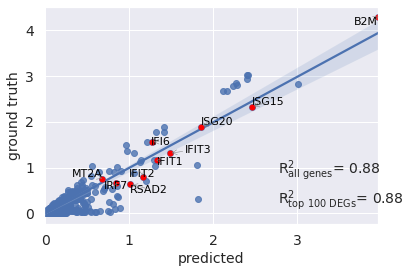

In [58]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "predicted stimulated", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes=diff_genes,
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False,
)

We can additionally look at the distribution of top upregulated genes by IFN-β.  For example, we plotted the distribution of expression in `ISG15`, a well-known gene induced after IFN stimulation.  As observed, the model identified that this gene should be upregulated after stimulation with IFN-β, and it indeed shifted values to a similar range in ground truth (stimulated) cells.

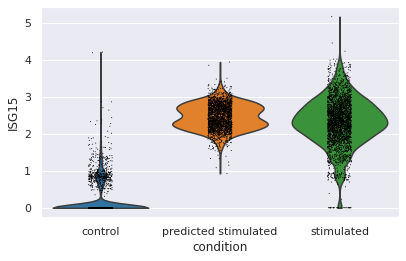

In [60]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

Overall, we demonstrated the application of scGen as an example of perturbation response models in predicting gene expression of the unseen population under desired perturbations. While perturbation response models provide in silico predictions, they cannot replace performing actual experiments. However, as observed in the case of scGen it can predict the overall response for highly expressed genes yet provide poorer predictions for lowly expressed genes, which requires further optimization and motivation for developing more sophisticated and robust approaches.  